In [18]:
import numpy as np
from pylab import *
import pandas as pd
%matplotlib inline

import scipy.io as sio
from scipy.signal import welch
from scipy.integrate import simps

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools


In [19]:
def bandpower(data, sf,window_sec=None, relative=False):
        """

        Parameters
        ----------
        data : 1d-array
            EEG data from a single electrode
        sf : float
            Sampling frequency
        window_sec : float
            Length of each window
            Default Value, window_sec = (1 / min(band)) * 2
        relative : boolean
            Relative Band Power(True) or Absolute (False)

        Return
        ------
        bp_arr : 1-d array
            Array of Absolute and Relative Band Power for Given Frequency Bands - Delta , Theta , Alpha , Beta , Gamma
        """

        
        eeg_bands = {'Delta': (1, 4),
                    'Theta': (4, 8),
                    'Alpha': (8, 12),
                    'Beta': (12, 30),
                    'Gamma': (30, 120)
                    }
        
        bp_arr = []
        for band in ['Delta','Theta','Alpha','Beta','Gamma']:
            low, high = eeg_bands[band][0],eeg_bands[band][1]
            
            # Define window length
            if window_sec is not None:
                nseg = window_sec * sf
            else:
                nseg = (2 / low) * sf
            if nseg > sf:
                nseg = sf
            # Compute the modified periodogram (Welch)
            freqs, psd = welch(data, sf, nperseg = nseg)

            # Frequency resolution
            freq_res = freqs[1] - freqs[0]

            # Find closest indices of band in frequency vector
            idx_band = np.logical_and(freqs >= low, freqs <= high)

            # Integral approximation of the spectrum using Simpson's rule.
            bp = simps(psd[idx_band], dx=freq_res)
            
            # relative to the overal bandpower of signal
            if relative:
                bp /= simps(psd, dx=freq_res)
            bp_arr.append(bp)
        return np.array(bp_arr)

In [20]:
mat = sio.loadmat('data\WLDataCW.mat')
datafile = 'data\WLDataCW.mat'
data_arr = sio.loadmat(datafile)
x_ = data_arr['data']
y_ = data_arr['label'].reshape(-1)

In [21]:

append = np.empty([0,310])

for sample in range(x_.shape[-1]):
    e_data = []
    for electrode in range(x_.shape[0]):
        e_data.append(bandpower(x_[electrode,:,sample],256,None,True))
    arr =np.array(e_data).reshape(1,-1)
    append = np.append(append,arr,axis=0)

In [22]:
x_ = np.array(append).transpose()

In [35]:
low_idx = np.argwhere(y_==0).reshape(-1)
medium_idx = np.argwhere(y_==1).reshape(-1)

indices = np.random.permutation(low_idx)

training_idx , test_idx = indices[:144] , indices[144:]

indices = np.random.permutation(medium_idx)
training_idx = np.append(training_idx ,indices[:144] )
test_idx = np.append(test_idx ,indices[144:])

print("Length of Train Set :" ,len(training_idx))
print("Length of Test Set :" ,len(test_idx))


x_train = x_[:,training_idx]
y_train = y_[training_idx]

x_test = x_[:,test_idx]
y_test = y_[test_idx]

Length of Train Set : 288
Length of Test Set : 72


In [36]:
y_train.shape

(288,)

In [60]:
import matplotlib.pyplot as plt
import numpy as np

class NN():
  def __init__(self,X,y):
    """ X : input matrix
        Y : GroundTruth matrix
    """
    self.X = X
    self.y = y
    self.W = np.random.normal(loc = 0.0, scale = 1e-2, size = (X.shape[0],y.shape[0]))
    self.b = np.random.normal(loc = 0.0, scale = 1e-2, size = (y.shape[0],1))
    # self.W = np.zeros((X.shape[0],y.shape[0]))
    # self.b = np.zeros(y.shape)
    self.loss_lst = []
  
  def activation(self,Z ,fn = 'sigmoid'):
    if fn == 'sigmoid':
      return 1/(1+np.exp(-Z))

  def log_loss(self,yHat, y):
    return y*np.log(yHat)+(1-y)*np.log(1 - yHat)

  def forward_propogation(self):
  # ''' Xin :input matrix y :ground truth matrix'''
    yhat = self.activation(np.matmul(self.W.transpose(),self.X) +self.b)
    loss = -1*(self.log_loss(yhat,self.y)).sum()/self.X.shape[1]
    return yhat,loss

  def fit(self,n,plot=True):
    for i in range(3000):
      yhat,loss = self.forward_propogation()
      wderv = self.X@np.transpose(yhat-self.y)/self.X.shape[1]
      bderv = np.sum(yhat-self.y)/self.X.shape[1]
      self.W = self.W - n * wderv
      self.b = self.b - n * bderv
      self.loss_lst.append(loss)
      # print(loss)
      if loss <=0.0001:
        break
    if plot:
      self.plot_loss()
    return self.W,self.b

  def plot_loss(self):
    plt.plot(self.loss_lst)
    plt.show()

  def predict(self,Xtest):
    return np.where(self.activation(np.matmul(self.W.transpose(),Xtest) +self.b).reshape(-1)>0.8,1,0)
  
  def plot_confusion_matrix(self,cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
  def accuray_report(self,Xtest,true,report=True):
    pred = self.predict(Xtest)
    if report:
      print(10*'*')
      print('Confusion Matrix')
      print(10*'*')
      cm = confusion_matrix(true , pred)
      print(cm)
      self.plot_confusion_matrix(cm,['Low','Medium'])
      
      print(10*'*')
      print('Classification Report')
      print(10*'*')
      print(classification_report(true , pred ))
    return accuracy_score(true,pred)

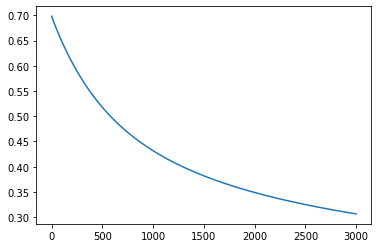

Minimum Loss Value 0.3064469745085704


In [61]:
Xtrain = x_train
ytrain = y_train.reshape(1,-1)

obj = NN(Xtrain,ytrain)
obj.fit(0.01)
print("Minimum Loss Value {}".format(obj.loss_lst[-1]))

In [67]:
from sklearn.model_selection import KFold
n = 3
kfold=KFold(n_splits=n,shuffle=True)
acc = 0
for fold,(train_idx,test_idx) in enumerate(kfold.split(y_train)):
    print('------------fold no-{}-------------'.format(fold))
    # print(x_train[:,train_idx].shape)
    # print(y_train[train_idx].shape)
    # print(x_train[:,test_idx].shape)
    # print(y_train[test_idx].shape)
    # print(train_idx)
    # print(test_idx)
    X = x_train[:,train_idx]
    Y = y_train[train_idx].reshape(1,-1)
    X_val = x_train[:,test_idx]
    Y_val = y_train[test_idx]
    if obj:
        del(obj)
    obj = NN(X,Y)
    obj.fit(0.01,False)
    acc_s = obj.accuray_report(X_val,Y_val,False)
    print(acc_s)
    acc +=acc_s
    

print('---------Cross Validation Accuracy----------')
print(acc/n)
print("Done")


------------fold no-0-------------
0.7708333333333334
------------fold no-1-------------
0.6875
------------fold no-2-------------
0.8020833333333334
---------Cross Validation Accuracy----------
0.7534722222222223
Done


**********
Confusion Matrix
**********
[[36  0]
 [18 18]]
Normalized confusion matrix
**********
Classification Report
**********
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        36
           1       1.00      0.50      0.67        36

    accuracy                           0.75        72
   macro avg       0.83      0.75      0.73        72
weighted avg       0.83      0.75      0.73        72



0.75

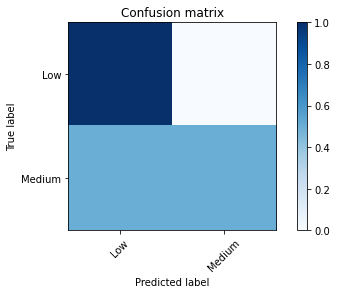

In [68]:
obj.accuray_report(x_test,y_test)